# Implicitly learning InterPro2GO annotations

In order to assess the effectiveness of our self-supervised learning pipeline, we investigate the scores predicted by our model for the domain-GO pairs from InterPro2GO annotation.


We perform this experiment in two different settings.

* SwissProt : We train on all the domain-GO pairs found in SwissProt dataset
* No-InterPro2GO : We use the same data, but discard the domain-GO pairs found in InterPro2GO mapping


Therefore, the No-InterPro2GO experiment is an extreme experiment of how much can be learned from context alone without the specific individual information 



## Importing modules

In [1]:
from tqdm import tqdm
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'DomainPFP')))
from domaingo_embedding_model import DomainGOEmbeddingModel, load_domaingo_embedding_model_weights

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and parse InterPro2GO annotations

We used InterPro2GO annotaiton of version date: 2022/03/16 10:40:04.

The annotation file can be found in ***../data***

In [2]:
fp = open('../data/interpro2go.txt','r')
dt = fp.read().split('\n')[:-1]
fp.close()

ipr2go_pairs = []
ipr2go_dict = {}
go_terms = set()
ipr_terms = set()

lines = 0

for ln in tqdm(dt):

    if ln[0]=='!':
        continue
    
    lines += 1
    intrpro_trm, go_trm = ln.split(' ')[0].split(':')[1],ln.split(' ')[-1]

    ipr_terms.add(intrpro_trm)
    go_terms.add(go_trm)

    ipr2go_pairs.append((intrpro_trm, go_trm))

    if intrpro_trm not in ipr2go_dict:
        ipr2go_dict[intrpro_trm] = {}
    ipr2go_dict[intrpro_trm][go_trm] = 1

100%|██████████| 35052/35052 [00:00<00:00, 214845.77it/s]


## Load data

In [3]:
domain_mappers_nointerpro2go = {}
domain_mappers_nointerpro2go['mf'] = pickle.load(open('../data/processed/domain_mapper_swissprot-nointerpro2go_mf.p','rb'))
domain_mappers_nointerpro2go['bp'] = pickle.load(open('../data/processed/domain_mapper_swissprot-nointerpro2go_bp.p','rb'))
domain_mappers_nointerpro2go['cc'] = pickle.load(open('../data/processed/domain_mapper_swissprot-nointerpro2go_cc.p','rb'))

go_mappers_nointerpro2go = {}
go_mappers_nointerpro2go['mf'] = pickle.load(open('../data/processed/go_mapper_swissprot-nointerpro2go_mf.p','rb'))
go_mappers_nointerpro2go['bp'] = pickle.load(open('../data/processed/go_mapper_swissprot-nointerpro2go_bp.p','rb'))
go_mappers_nointerpro2go['cc'] = pickle.load(open('../data/processed/go_mapper_swissprot-nointerpro2go_cc.p','rb'))

all_domain_proteins_nointerpro2go = {}
all_domain_proteins_nointerpro2go['mf'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_mf.p','rb'))
all_domain_proteins_nointerpro2go['bp'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_bp.p','rb'))
all_domain_proteins_nointerpro2go['cc'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_cc.p','rb'))

all_go_proteins_nointerpro2go = {}
all_go_proteins_nointerpro2go['mf'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_mf.p','rb'))
all_go_proteins_nointerpro2go['bp'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_bp.p','rb'))
all_go_proteins_nointerpro2go['cc'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_cc.p','rb'))

domain_mappers_swissprot = {}
domain_mappers_swissprot['mf'] = pickle.load(open('../data/processed/domain_mapper_swissprot_mf.p','rb'))
domain_mappers_swissprot['bp'] = pickle.load(open('../data/processed/domain_mapper_swissprot_bp.p','rb'))
domain_mappers_swissprot['cc'] = pickle.load(open('../data/processed/domain_mapper_swissprot_cc.p','rb'))

go_mappers_swissprot = {}
go_mappers_swissprot['mf'] = pickle.load(open('../data/processed/go_mapper_swissprot_mf.p','rb'))
go_mappers_swissprot['bp'] = pickle.load(open('../data/processed/go_mapper_swissprot_bp.p','rb'))
go_mappers_swissprot['cc'] = pickle.load(open('../data/processed/go_mapper_swissprot_cc.p','rb'))

all_domain_proteins_swissprot = {}
all_domain_proteins_swissprot['mf'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_mf.p','rb'))
all_domain_proteins_swissprot['bp'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_bp.p','rb'))
all_domain_proteins_swissprot['cc'] = pickle.load(open('../data/processed/all_domain_proteins_swissprot_cc.p','rb'))

all_go_proteins_swissprot = {}
all_go_proteins_swissprot['mf'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_mf.p','rb'))
all_go_proteins_swissprot['bp'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_bp.p','rb'))
all_go_proteins_swissprot['cc'] = pickle.load(open('../data/processed/all_go_proteins_swissprot_cc.p','rb'))


## Load models

In [4]:
mdl_nointerpro2go = {}
for onto in ['mf','bp','cc']:
    mdl_nointerpro2go[onto] = DomainGOEmbeddingModel(domain_mappers_nointerpro2go[onto], go_mappers_nointerpro2go[onto])                       # create a model
    mdl_nointerpro2go[onto] = load_domaingo_embedding_model_weights(mdl_nointerpro2go[onto], f'../saved_models/swissprot-nointerpro2go_{onto}')   # load model weights

mdl_swissprot = {}
for onto in ['mf','bp','cc']:
    mdl_swissprot[onto] = DomainGOEmbeddingModel(domain_mappers_swissprot[onto], go_mappers_swissprot[onto])                 # create a model
    mdl_swissprot[onto] = load_domaingo_embedding_model_weights(mdl_swissprot[onto], f'../saved_models/swissprot_{onto}')   # load model weights

## Test scores for Domain-GO pairs 

In [5]:
def compute_model_prediction(domain, GO, print_opt=False):
    """
    Compute and return the prediction score for both the SwissProt and No-InterPro2GO models

    Args:
        domain (str): the input Domain
        GO (str): the input GO term
        print_opt (bool, optional): printing option. Defaults to False.
    """

    scores = {
                'SwissProt':None,
                'No-InterPro2GO':None
            }


    if print_opt:
        print('SwissProt Model')
    if (domain not in domain_mappers_swissprot['mf']) and (domain not in domain_mappers_swissprot['bp']) and (domain not in domain_mappers_swissprot['cc']):
        if print_opt:
            print(f'Domain {domain} is not present in our SwissProt dataset')
    else:
        for onto in ['mf','bp','cc','']:
            if onto=='':
                if print_opt:
                    print(f'GO term {GO} is not present in our SwissProt dataset OR Domain {domain} is not present in our SwissProt dataset')
            elif (GO in go_mappers_swissprot[onto]) and (domain in domain_mappers_swissprot[onto]):
                scores['onto'] = onto.upper() + 'O'
                scores['SwissProt'] = np.clip(mdl_swissprot[onto](torch.Tensor([domain_mappers_swissprot[onto][domain]]).to(torch.int64),torch.Tensor([go_mappers_swissprot[onto][GO]]).to(torch.int64))[0].detach().numpy()[0][0],0,1)
                if print_opt:
                    print(f"p({GO}|{domain}) = {round(len(all_domain_proteins_swissprot[onto][domain].intersection(all_go_proteins_swissprot[onto][GO]))/len(all_domain_proteins_swissprot[onto][domain]) ,2)}")
                    print(f'Model prediction {round(np.clip(mdl_swissprot[onto](torch.Tensor([domain_mappers_swissprot[onto][domain]]).to(torch.int64),torch.Tensor([go_mappers_swissprot[onto][GO]]).to(torch.int64))[0].detach().numpy()[0][0],0,1),2)}')                                                                    
                break
    if print_opt:
        print('---')
        print('No-InetrPro2GO Model')
    if (domain not in domain_mappers_nointerpro2go['mf']) and (domain not in domain_mappers_nointerpro2go['bp']) and (domain not in domain_mappers_nointerpro2go['cc']):
        if print_opt:
            print(f'Domain {domain} is not present in our no-InterPro2GO dataset')
    else:
        for onto in ['mf','bp','cc','']:
            if onto=='':
                if print_opt:
                    print(f'GO term {GO} is not present in our no-InterPro2GO dataset OR Domain {domain} is not present in our no-InterPro2GO dataset')
                    
            elif (GO in go_mappers_nointerpro2go[onto]) and (domain in domain_mappers_nointerpro2go[onto]):
                scores['No-InterPro2GO'] = np.clip(mdl_nointerpro2go[onto](torch.Tensor([domain_mappers_nointerpro2go[onto][domain]]).to(torch.int64),torch.Tensor([go_mappers_nointerpro2go[onto][GO]]).to(torch.int64))[0].detach().numpy()[0][0],0,1)
                if print_opt:
                    print(f"p({GO}|{domain}) = {round(len(all_domain_proteins_nointerpro2go[onto][domain].intersection(all_go_proteins_nointerpro2go[onto][GO]))/len(all_domain_proteins_nointerpro2go[onto][domain]) ,2)}")
                    print(f'Model prediction {round(np.clip(mdl_nointerpro2go[onto](torch.Tensor([domain_mappers_nointerpro2go[onto][domain]]).to(torch.int64),torch.Tensor([go_mappers_nointerpro2go[onto][GO]]).to(torch.int64))[0].detach().numpy()[0][0],0,1),2)}')                                                                    
                break
    
    if (scores['No-InterPro2GO'] is None) or (scores['SwissProt'] is None):
        scores['onto'] = ''

    return scores

### Positive Example

In [6]:
compute_model_prediction('IPR000003','GO:0006355',print_opt=True)

SwissProt Model
p(GO:0006355|IPR000003) = 1.0
Model prediction 1.0
---
No-InetrPro2GO Model
p(GO:0006355|IPR000003) = 1.0
Model prediction 1.0


{'SwissProt': 1.0, 'No-InterPro2GO': 1.0, 'onto': 'BPO'}

### Negative Example

In [7]:
compute_model_prediction('IPR000003','GO:0042925',print_opt=True)

SwissProt Model
p(GO:0042925|IPR000003) = 0.0
Model prediction 0.0
---
No-InetrPro2GO Model
p(GO:0042925|IPR000003) = 0.0
Model prediction 0.0


{'SwissProt': 3.18610473186709e-05,
 'No-InterPro2GO': 0.0004504761309362948,
 'onto': 'MFO'}

## Compute predictions scores for all InterPro2GO pairs

Model predicted scores for all the interpro2GO pairs are computed and stored in a dataframe for further analysis

In [8]:
match_scores_df = []
match_scores_dict = {
    'MFO':{'SwissProt':[],'No-InterPro2GO':[]},
    'BPO':{'SwissProt':[],'No-InterPro2GO':[]},
    'CCO':{'SwissProt':[],'No-InterPro2GO':[]},
    'ALL':{'SwissProt':[],'No-InterPro2GO':[]},
}

for intrpro_trm in tqdm(ipr2go_dict):
    for go_trm in ipr2go_dict[intrpro_trm]:
        scr = compute_model_prediction(intrpro_trm,go_trm)

        if scr['onto'] != '':
            match_scores_dict[scr['onto']]['SwissProt'].append(scr['SwissProt'])
            match_scores_dict[scr['onto']]['No-InterPro2GO'].append(scr['No-InterPro2GO'])

            match_scores_dict['ALL']['SwissProt'].append(scr['SwissProt'])
            match_scores_dict['ALL']['No-InterPro2GO'].append(scr['No-InterPro2GO'])

for onto in match_scores_dict:
    for mthd in match_scores_dict[onto]:
        match_scores_dict[onto][mthd] = list(np.histogram(match_scores_dict[onto][mthd],bins=10))[0]


for onto in ['MFO','BPO','CCO','ALL']:
    for mthd in ['No-InterPro2GO','SwissProt']:
        for i in range(10):
            match_scores_df.append([
                onto,
                round(100*match_scores_dict[onto][mthd][i]/np.sum(match_scores_dict[onto][mthd]),3),
                match_scores_dict[onto][mthd][i],
                f'{i/10}-{(i+1)/10}',
                'ipr2go pairs included' if mthd=='SwissProt' else 'ipr2go pairs removed'
            ])

match_scores_df = pd.DataFrame(match_scores_df, columns=['Onto','Percent','Count','Score','Model'])


100%|██████████| 16443/16443 [00:18<00:00, 869.87it/s] 


### Observe Scores

In [9]:
match_scores_df

,Onto,Percent,Count,Score,Model
0,MFO,21.858,3263,0.0-0.1,ipr2go pairs removed
1,MFO,2.867,428,0.1-0.2,ipr2go pairs removed
2,MFO,2.680,400,0.2-0.3,ipr2go pairs removed
3,MFO,2.914,435,0.3-0.4,ipr2go pairs removed
4,MFO,3.236,483,0.4-0.5,ipr2go pairs removed
...,...,...,...,...,...
75,ALL,0.472,164,0.5-0.6,ipr2go pairs included
76,ALL,0.771,268,0.6-0.7,ipr2go pairs included
77,ALL,1.681,584,0.7-0.8,ipr2go pairs included
78,ALL,6.398,2223,0.8-0.9,ipr2go pairs included


### Number of Interpro2GO pairs with >=0.5 score

In [10]:
match_scores_df[(match_scores_df['Score']=='0.5-0.6') | (match_scores_df['Score']=='0.6-0.7') | (match_scores_df['Score']=='0.7-0.8') | (match_scores_df['Score']=='0.8-0.9') | (match_scores_df['Score']=='0.9-1.0')].groupby(['Model','Onto']).sum()


/tmp/ipykernel_2371951/2303777427.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  match_scores_df[(match_scores_df['Score']=='0.5-0.6') | (match_scores_df['Score']=='0.6-0.7') | (match_scores_df['Score']=='0.7-0.8') | (match_scores_df['Score']=='0.8-0.9') | (match_scores_df['Score']=='0.9-1.0')].groupby(['Model','Onto']).sum()


Percent  Count
Model                 Onto                
ipr2go pairs included ALL    96.877  33661
                      BPO    98.182  13339
                      CCO    98.235   6122
                      MFO    95.124  14200
ipr2go pairs removed  ALL    76.086  26437
                      BPO    81.885  11125
                      CCO    86.538   5393
                      MFO    66.445   9919

### Plot the results

/tmp/ipykernel_2371951/910496406.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{x}%' for x in np.round(ax1.get_yticks()*100/match_scores_df[match_scores_df['Onto']==onto][match_scores_df[match_scores_df['Onto']==onto]['Model']=='ipr2go pairs included']['Count'].sum(),1)]);
/tmp/ipykernel_2371951/910496406.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{x}%' for x in np.round(ax1.get_yticks()*100/match_scores_df[match_scores_df['Onto']==onto][match_scores_df[match_scores_df['Onto']==onto]['Model']=='ipr2go pairs included']['Count'].sum(),1)]);
/tmp/ipykernel_2371951/910496406.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{x}%' for x in np.round(ax1.get_yticks()*100/match_scores_df[match_scores_df['Onto']==onto][match_scores_df[match_scores_df['Onto']==onto]['Model']=='ipr2go pairs included']['Count'].sum(),1

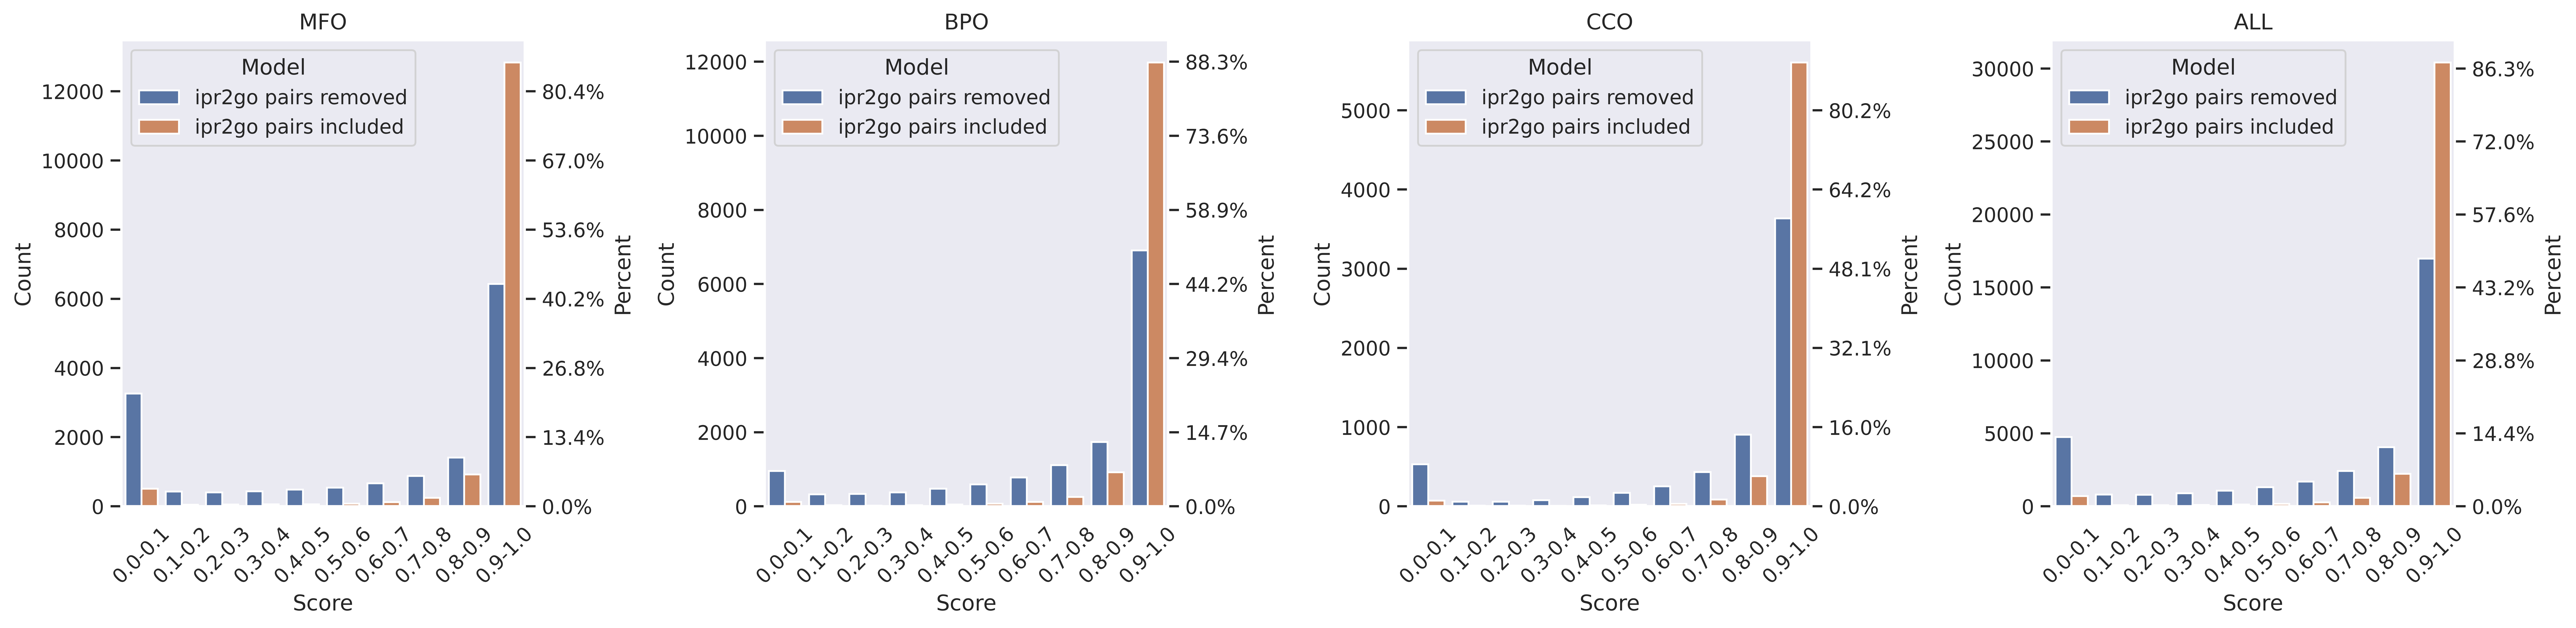

In [11]:
sns.set()
sns.set_style( {'axes.grid' : False})

plt.figure(figsize=(20,5),dpi=600);

i = 1
for onto in ['MFO','BPO','CCO','ALL']:
    fig = plt.subplot(1,4,i)
    ax1 = plt.gca()
    i+=1
    
    #fig, ax1 = plt.subplots();
    g = sns.barplot(data=match_scores_df[match_scores_df['Onto']==onto],x='Score',y='Count',hue='Model');
    ax1.set_ylabel('Count');
    ax2 = ax1.twinx();
    ax2.set_ylim(ax1.get_ylim());
    ax2.set_yticklabels([f'{x}%' for x in np.round(ax1.get_yticks()*100/match_scores_df[match_scores_df['Onto']==onto][match_scores_df[match_scores_df['Onto']==onto]['Model']=='ipr2go pairs included']['Count'].sum(),1)]);
    ax2.set_ylabel('Percent');
    ax1.tick_params(axis='x', rotation=45);
    
    plt.xlabel('Predicted Score')
    plt.title(onto)

plt.tight_layout()

